# Speckle noise in Sentinel-1


Speckle noise is multiplicative 

Y=NX

and

p(N)= $\frac{L^{L} N^{L-1}e^{-L N}}{\Gamma(L)}$

where L is number of looks


Equivalent number of looks can be estimated as $mean^2/std^2$

In [1]:
%matplotlib inline
import numpy as np
import datacube

In [14]:
from scipy.ndimage.filters import uniform_filter

def temporal_filter(da, size):
    """
    Multi-temporal filtering from S. Quegan 2001
    Input is a 3d data array or a dataset with 3d array as variables
    """
    M = len(da.time)
    img_mean = da.groupby('time').apply(uniform_filter, (size, size))
    return img_mean*(da/img_mean).sum(dim='time')/M

In [3]:
from matplotlib import pyplot as plt

In [6]:
dc = datacube.Datacube(config='radar.conf')

In [7]:
prod_dc = datacube.Datacube()

In [18]:
# sunshine coast for uniform forest 
# speckle distribution
query = {
'y': (-26.74, -26.70), 
'x': (152.56, 152.60),
'time':('2015-01-01','2020-01-01'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (25, -25)
}

# Sydney
query = {
'y': (-33.875, -33.865), 
'x': (151.21, 151.22),
'time':('2015-01-01','2019-01-01'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (25, -25)
}


In [19]:
radar = dc.load(product='s1_gamma0_scene_v6', group_by='solar_day', **query)

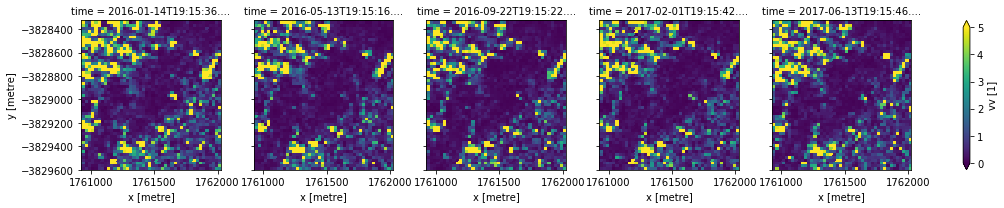

In [21]:
radar.vv.isel(time=slice(0,50,10)).plot(col='time', vmin=0, vmax=5)

In [24]:
valid_bands = ['vv', 'vh', 'hh', 'hv']
bands = [b for b in list(radar.data_vars) if b.lower() in valid_bands]

filtered = radar[bands].copy()
filter_size = 5
for band in bands:
    filtered[band] = temporal_filter(radar[band], size=filter_size)

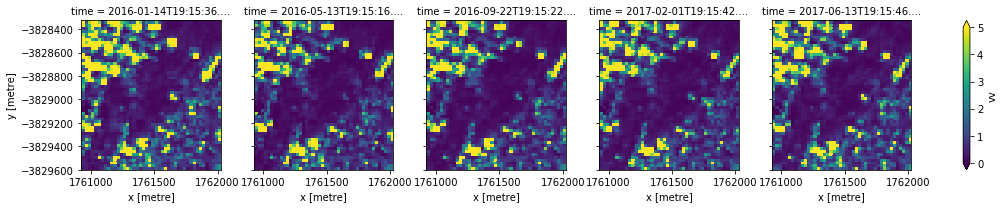

In [26]:
filtered.vv.isel(time=slice(0,50,10)).plot(col='time', vmin=0, vmax=5)

In [9]:
gm = prod_dc.load(product ='ls8_nbart_geomedian_annual', 
                   time=('2017-01-01','2017-02-01'),
                   lat=query['y'], lon=query['x'], output_crs = query['output_crs'],
                   resolution=query['resolution'])